In [1]:
# reference1: https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572
# reference2: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/
# by Terry Zhang in Mystic coders

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

In [3]:
home = pd.read_csv('forecast_your.csv', low_memory=False)
pd.set_option('display.float_format', lambda x:'%f'%x)

In [4]:
home['Date'] = home['YEAR'].apply(str)+'-'+home['MO'].apply(str)+'-'+home['DY'].apply(str)

In [5]:
home['mean_kilowatt_per_hour'] = pd.to_numeric(home['mean_kilowatt_per_hour'])
home['kilowatt_per_day'] = (home['mean_kilowatt_per_hour']*24)

In [6]:
sub2 = home[['Date', 'kilowatt_per_day']].replace(-999, np.nan)

In [7]:
sub2['Date'] = pd.to_datetime(sub2['Date'], format='%Y-%m-%d')

In [8]:
sub2 = sub2.set_index('Date') 
sub2 = sub2.dropna(subset=['kilowatt_per_day'])

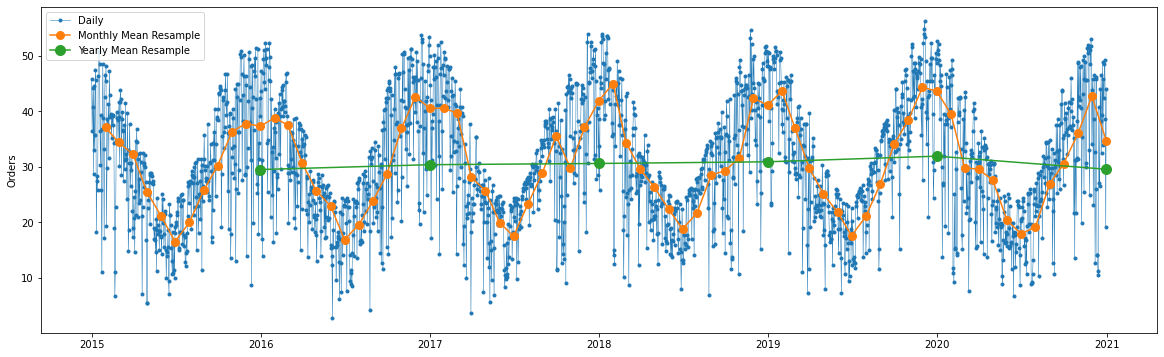

In [9]:
%matplotlib inline
y = sub2['kilowatt_per_day']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(y.resample('Y').mean(),marker='o', markersize=10, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

In [10]:
sub2.index.freq = 'D'

In [11]:
start_time = home.loc[1, 'Date']

In [12]:
sub3 = sub2.copy()
sub3['Date'] = pd.date_range(start_time, periods = len(home), freq= "D")

In [13]:
Date = pd.date_range(sub3.index[-1], periods=365, freq='D')[1:]

fsub = pd.DataFrame(np.repeat(0, len(Date)))

fsub['Date'] = Date
fsub = fsub.set_index('Date') 
fsub = fsub.rename(columns={0: "kilowatt_per_day"})

In [14]:
sub3 = sub3.drop(['Date'], axis=1)

In [15]:
sub3 = sub3.append(fsub)

In [16]:
df_train = sub3.iloc[:-365]
df_test = sub3.iloc[-365:]

In [17]:
model = HWES(df_train, seasonal_periods=365, trend='additive', seasonal='additive')
fitted = model.fit(optimized=True, use_brute=True)

D:\Programming\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
D:\Programming\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [18]:
forecast = fitted.forecast(steps=365)

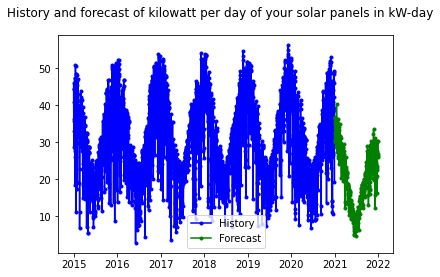

In [19]:
fig = plt.figure()
fig.suptitle('History and forecast of kilowatt per day of your solar panels in kW-day')
past, = plt.plot(df_train.index, df_train, 'b.-', label='History')
predicted_future, = plt.plot(df_test.index, forecast, 'g.-', label='Forecast')
plt.legend(handles=[past, predicted_future])
plt.show()